# Data Fetch and Preparation



In [1]:
!nvidia-smi

Fri Dec 27 15:09:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [4]:
!pip install patchify

In [5]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot as plt
import random

from tensorflow.keras.utils import to_categorical
import seaborn as sns

In [6]:
print(tf.__version__)

2.17.0


In [7]:
minmaxscaler = MinMaxScaler()

(6310, 6911)

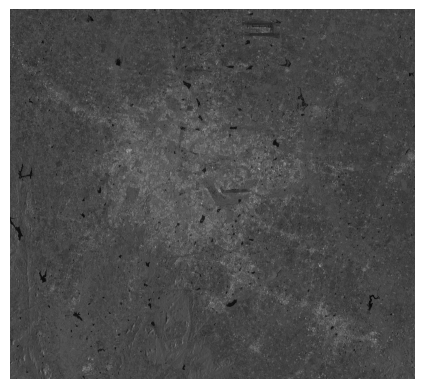

In [8]:
image = cv2.imread('/kaggle/input/sar-data/KAT_S1_median_VV_2022_Coregd_Despkl.tif',-1)
plt.imshow(image, 'gray')
plt.axis('off')
image.shape

(6310, 6911)

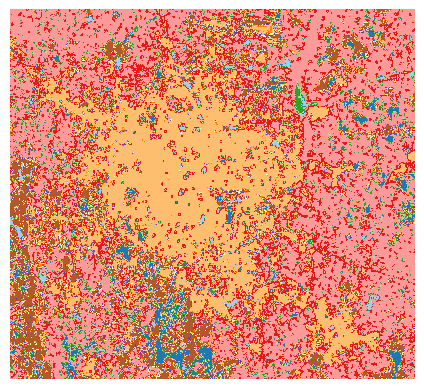

In [9]:
mask = cv2.imread('/kaggle/input/sar-data/ESRI_KAT_ROI_2022_Coreg.tif',-1)
plt.imshow(mask,'Paired')
plt.axis('off')
mask.shape

In [10]:
image_patch_size = 128

In [11]:
if image is not None:
    print(image.shape)

    size_x = (image.shape[1] // image_patch_size) * image_patch_size
    size_y = (image.shape[0] // image_patch_size) * image_patch_size
    print(f"{image.shape} --- {size_x} - {size_y}")
    image = Image.fromarray(image).crop((0, 0, size_x, size_y))
    print(f"({image.size[0]},  {image.size[1]})")
    image = np.array(image)

    patched_images = patchify(image, (image_patch_size, image_patch_size), step=image_patch_size)
    print(patched_images.shape)

    # Flatten patched_images array to 2D
    patched_images_flattened = patched_images.reshape(-1, patched_images.shape[2], patched_images.shape[3])
    print(patched_images_flattened.shape)

(6310, 6911)
(6310, 6911) --- 6784 - 6272
(6784,  6272)
(49, 53, 128, 128)
(2597, 128, 128)


In [12]:
if mask is not None:
    print(mask.shape)

    size_x = (mask.shape[1] // image_patch_size) * image_patch_size
    size_y = (mask.shape[0] // image_patch_size) * image_patch_size
    print(f"{mask.shape} --- {size_x} - {size_y}")
    mask = Image.fromarray(mask).crop((0, 0, size_x, size_y))
    print(f"({mask.size[0]},  {mask.size[1]})")
    mask = np.array(mask)

    patched_masks = patchify(mask, (image_patch_size, image_patch_size), step=image_patch_size)
    print(patched_masks.shape)

    # Flatten patched_masks array to 2D
    patched_masks_flattened = patched_masks.reshape(-1, patched_masks.shape[2], patched_masks.shape[3])
    print(patched_masks_flattened.shape)

(6310, 6911)
(6310, 6911) --- 6784 - 6272
(6784,  6272)
(49, 53, 128, 128)
(2597, 128, 128)


In [13]:
image_dataset = np.array(patched_images_flattened)
mask_dataset = np.array(patched_masks_flattened)

In [14]:
print(image_dataset.shape)
print(mask_dataset.shape)

(2597, 128, 128)
(2597, 128, 128)


(-0.5, 127.5, 127.5, -0.5)

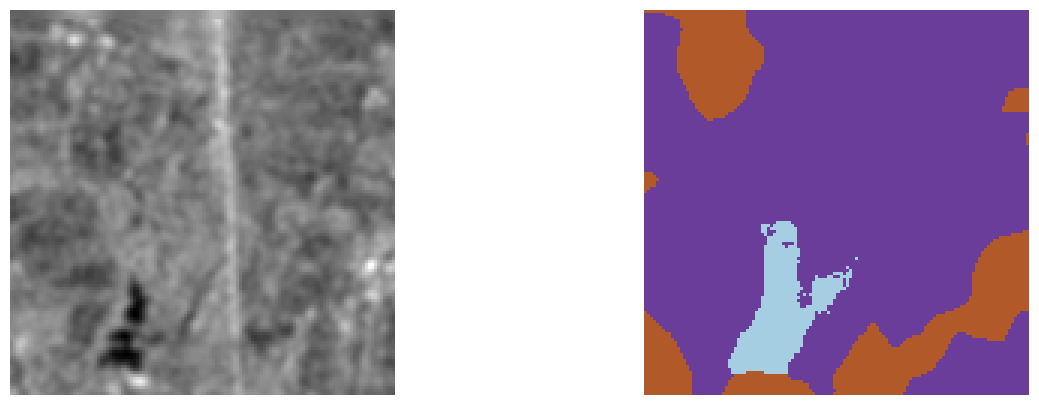

In [15]:
index= 20
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(image_dataset[index], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask_dataset[index], cmap='Paired')
plt.axis('off')

In [16]:
def merge_classes(mask_image):
    mask_image_copy = mask_image.copy()

    # Define mapping based on merging rules
    merge_class_map = {
        3: 1,  # Flooded Vegetation becomes Water
        6: 4,  # Bare Ground becomes Crops
        7: 4,  # Snow/Ice becomes Crops
        8: 4,  # Clouds becomes Crops
        9: 4   # Rangeland becomes Crops
    }

    # Apply the merging
    for original_class, new_class in merge_class_map.items():
        mask_image_copy[np.where(mask_image_copy == original_class)] = new_class

    # Define final relabeling to align with target_class_dict
    final_relabel_map = {
        1: 0,  # Water
        4: 1,  # Cropland
        2: 3,  # Treecover
        5: 2,  # Builtup
    }

    # Apply the final relabeling
    for original_label, new_label in final_relabel_map.items():
        mask_image_copy[np.where(mask_image_copy == original_label)] = new_label

    return mask_image_copy


In [17]:
labels_dataset = []
for i in range(mask_dataset.shape[0]):
        merged_mask = merge_classes(mask_dataset[i])
        labels_dataset.append(merged_mask)
labels_dataset = np.array(labels_dataset)
print(f"Labels shape:", labels_dataset.shape)

Labels shape: (2597, 128, 128)


In [18]:
before_Water = len(np.where(mask_dataset.flatten()==1)[0])
before_Trees =   len(np.where(mask_dataset.flatten()==2)[0])
before_Flooded_Vegetation =   len(np.where(mask_dataset.flatten()==3)[0])
before_Crops =   len(np.where(mask_dataset.flatten()==4)[0])
before_BuiltArea =   len(np.where(mask_dataset.flatten()==5)[0])
before_BareGround =   len(np.where(mask_dataset.flatten()==6)[0])
before_SnowIce =   len(np.where(mask_dataset.flatten()==7)[0])
before_Clouds =   len(np.where(mask_dataset.flatten()==8)[0])
before_Rangeland =   len(np.where(mask_dataset.flatten()==9)[0])

after_Water =   len(np.where(labels_dataset.flatten()==0)[0])
after_Trees =   len(np.where(labels_dataset.flatten()==3)[0])
after_Crops =   len(np.where(labels_dataset.flatten()==1)[0])
after_BuiltArea =   len(np.where(labels_dataset.flatten()==2)[0])

assert (before_Water+before_Flooded_Vegetation) == after_Water, "Water does not match"
assert (before_Crops+before_BareGround+before_SnowIce+before_Clouds+before_Rangeland) == after_Crops, "Crops does not match"
assert before_Trees == after_Trees, "Trees does not match"
assert before_BuiltArea == after_BuiltArea, "BuiltArea does not match"
print(' Merge Validation Passed')
print(' Water = ', np.round(after_Water/(labels_dataset.flatten().shape[0]), 3),
                        ' Trees = ', np.round(after_Trees/(labels_dataset.flatten().shape[0]), 3),
                        ' Bareland = ', np.round(after_Crops/(labels_dataset.flatten().shape[0]), 3),
                        ' BuiltArea = ', np.round(after_BuiltArea/(labels_dataset.flatten().shape[0]), 3))

 Merge Validation Passed
 Water =  0.022  Trees =  0.065  Bareland =  0.524  BuiltArea =  0.389


In [19]:
print(labels_dataset[0].shape)
print(image_dataset[0].shape)

(128, 128)
(128, 128)


In [20]:
np.unique(labels_dataset)

array([0., 1., 2., 3.], dtype=float32)

2517


(-0.5, 127.5, 127.5, -0.5)

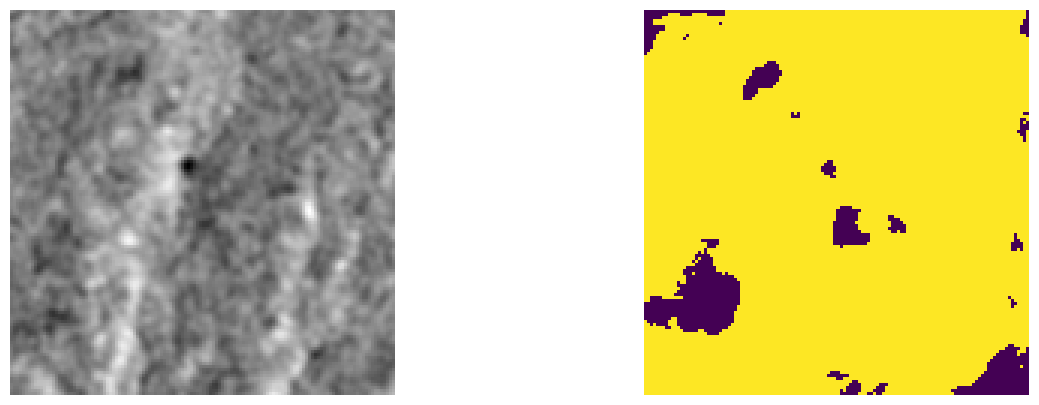

In [21]:
index= np.random.choice(image_dataset.shape[0], 1)[0]
print(index)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(image_dataset[index], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(labels_dataset[index],)
plt.axis('off')

TEST DATASET (2023)

In [22]:
# test_image = cv2.imread('/content/drive/My Drive/Colab Notebooks/SAR_PE/2023_Data/KAT_S1_median_VV_2023_Despk_boxcar_ls7pt5.tif',-1)
# plt.imshow(test_image, 'gray')
# plt.axis('off')
# test_image.shape

In [23]:
# test_mask = cv2.imread('/content/drive/My Drive/Colab Notebooks/SAR_PE/2023_Data/ESRI_KAT_ROI_2023.tif',-1)
# plt.imshow(test_mask,'Paired')
# plt.axis('off')
# test_mask.shape

In [24]:
# if test_image is not None:
#     print(test_image.shape)

#     size_x = (test_image.shape[1] // image_patch_size) * image_patch_size
#     size_y = (test_image.shape[0] // image_patch_size) * image_patch_size
#     print(f"{test_image.shape} --- {size_x} - {size_y}")
#     test_image = Image.fromarray(test_image).crop((0, 0, size_x, size_y))
#     print(f"({test_image.size[0]},  {test_image.size[1]})")
#     test_image = np.array(test_image)

#     test_patched_images = patchify(test_image, (image_patch_size, image_patch_size), step=image_patch_size)
#     print(test_patched_images.shape)

#     # Flatten patched_images array to 2D
#     test_patched_images_flattened = test_patched_images.reshape(-1, test_patched_images.shape[2], test_patched_images.shape[3])
#     print(test_patched_images_flattened.shape)

In [25]:
# if test_mask is not None:
#     print(test_mask.shape)

#     size_x = (test_mask.shape[1] // image_patch_size) * image_patch_size
#     size_y = (test_mask.shape[0] // image_patch_size) * image_patch_size
#     print(f"{test_mask.shape} --- {size_x} - {size_y}")
#     test_mask = Image.fromarray(test_mask).crop((0, 0, size_x, size_y))
#     print(f"({test_mask.size[0]},  {test_mask.size[1]})")
#     test_mask = np.array(test_mask)

#     test_patched_masks = patchify(test_mask, (image_patch_size, image_patch_size), step=image_patch_size)
#     print(test_patched_masks.shape)

#     # Flatten patched_masks array to 2D
#     test_patched_masks_flattened = test_patched_masks.reshape(-1,test_patched_masks.shape[2], test_patched_masks.shape[3])
#     print(test_patched_masks_flattened.shape)

In [26]:
# test_image_dataset = np.array(test_patched_images_flattened)
# test_mask_dataset = np.array(test_patched_masks_flattened)

In [27]:
# index= 20
# plt.figure(figsize=(15, 5))
# plt.subplot(1,2,1)
# plt.imshow(test_image_dataset[index], cmap='gray')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(test_mask_dataset[index], cmap='Paired')
# plt.axis('off')

In [28]:
# test_labels_dataset = []
# for i in range(test_mask_dataset.shape[0]):
#         test_merged_mask = merge_classes(test_mask_dataset[i])
#         test_labels_dataset.append(test_merged_mask)
# test_labels_dataset = np.array(test_labels_dataset)
# print(f"Labels shape:", test_labels_dataset.shape)

In [29]:
# before_Water = len(np.where(mask_dataset.flatten()==1)[0])
# before_Trees =   len(np.where(mask_dataset.flatten()==2)[0])
# before_Flooded_Vegetation =   len(np.where(mask_dataset.flatten()==3)[0])
# before_Crops =   len(np.where(mask_dataset.flatten()==4)[0])
# before_BuiltArea =   len(np.where(mask_dataset.flatten()==5)[0])
# before_BareGround =   len(np.where(mask_dataset.flatten()==6)[0])
# before_SnowIce =   len(np.where(mask_dataset.flatten()==7)[0])
# before_Clouds =   len(np.where(mask_dataset.flatten()==8)[0])
# before_Rangeland =   len(np.where(mask_dataset.flatten()==9)[0])

# after_Water =   len(np.where(labels_dataset.flatten()==0)[0])
# after_Trees =   len(np.where(labels_dataset.flatten()==3)[0])
# after_Crops =   len(np.where(labels_dataset.flatten()==1)[0])
# after_BuiltArea =   len(np.where(labels_dataset.flatten()==2)[0])

# assert (before_Water+before_Flooded_Vegetation) == after_Water, "Water does not match"
# assert (before_Crops+before_BareGround+before_SnowIce+before_Clouds+before_Rangeland) == after_Crops, "Crops does not match"
# assert before_Trees == after_Trees, "Trees does not match"
# assert before_BuiltArea == after_BuiltArea, "BuiltArea does not match"
# print(' Merge Validation Passed')
# print(' Water = ', np.round(after_Water/(labels_dataset.flatten().shape[0]), 3),
#                         ' Trees = ', np.round(after_Trees/(labels_dataset.flatten().shape[0]), 3),
#                         ' Bareland = ', np.round(after_Crops/(labels_dataset.flatten().shape[0]), 3),
#                         ' BuiltArea = ', np.round(after_BuiltArea/(labels_dataset.flatten().shape[0]), 3))

In [30]:
# index= np.random.choice(test_image_dataset.shape[0], 1)[0]
# print(index)
# plt.figure(figsize=(15, 5))
# plt.subplot(1,2,1)
# plt.imshow(test_image_dataset[index], cmap='gray')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(test_labels_dataset[index],)
# plt.axis('off')

In [31]:
n_classes = 4

In [32]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.optimizers import Adam

# def unet_model(input_size=(128, 128, 1), n_classes=4):
#     inputs = layers.Input(input_size)

#     # Encoder (Contracting Path)
#     conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = layers.MaxPooling2D((2, 2))(conv1)

#     conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = layers.MaxPooling2D((2, 2))(conv2)

#     conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
#     pool3 = layers.MaxPooling2D((2, 2))(conv3)

#     conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
#     pool4 = layers.MaxPooling2D((2, 2))(conv4)

#     # Bottleneck
#     conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
#     conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#     # Decoder (Expanding Path)
#     up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
#     up6 = layers.concatenate([conv4, up6], axis=3)
#     conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
#     conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

#     up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
#     up7 = layers.concatenate([conv3, up7], axis=3)
#     conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
#     conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

#     up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
#     up8 = layers.concatenate([conv2, up8], axis=3)
#     conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
#     conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

#     up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
#     up9 = layers.concatenate([conv1, up9], axis=3)
#     conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
#     conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

#     # Output layer for multi-class segmentation (softmax for multi-class classification)
#     outputs = layers.Conv2D(n_classes, (1, 1), activation='softmax')(conv9)

#     model = models.Model(inputs=[inputs], outputs=[outputs])

#     return model

# # Compile the model for multi-class segmentation
# model = unet_model(input_size=(128, 128, 1), n_classes=4)  # 4 classes for segmentation
# model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# # Show model summary
# model.summary()

In [33]:
# # LIGHTER VERSION OF CODE
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.optimizers import Adam

# def lightweight_unet(input_size=(128, 128, 1), n_classes=4):
#     inputs = layers.Input(input_size)

#     # Encoder (Contracting Path)
#     conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = layers.MaxPooling2D((2, 2))(conv1)

#     conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = layers.MaxPooling2D((2, 2))(conv2)

#     # Bottleneck
#     conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

#     # Decoder (Expanding Path)
#     up4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)
#     up4 = layers.concatenate([conv2, up4], axis=3)
#     conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
#     conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

#     up5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4)
#     up5 = layers.concatenate([conv1, up5], axis=3)
#     conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
#     conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

#     # Output layer
#     outputs = layers.Conv2D(n_classes, (1, 1), activation='softmax')(conv5)

#     model = models.Model(inputs=[inputs], outputs=[outputs])

#     return model

# # Compile the lighter model
# model = lightweight_unet(input_size=(128, 128, 1), n_classes=4)
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Show the model summary
# model.summary()


In [34]:
# # MORE LIGHTER VERSION
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.optimizers import Adam

# def ultra_lightweight_unet(input_size=(128, 128, 1), n_classes=4):
#     inputs = layers.Input(input_size)

#     # Encoder (Contracting Path)
#     conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
#     pool1 = layers.MaxPooling2D((2, 2))(conv1)

#     conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
#     pool2 = layers.MaxPooling2D((2, 2))(conv2)

#     # Bottleneck
#     conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)

#     # Decoder (Expanding Path)
#     up4 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv3)
#     up4 = layers.concatenate([conv2, up4], axis=3)
#     conv4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up4)

#     up5 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv4)
#     up5 = layers.concatenate([conv1, up5], axis=3)
#     conv5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(up5)

#     # Output layer
#     outputs = layers.Conv2D(n_classes, (1, 1), activation='softmax')(conv5)

#     model = models.Model(inputs=[inputs], outputs=[outputs])

#     return model

# # Compile the ultra-lightweight model
# model = ultra_lightweight_unet(input_size=(128, 128, 1), n_classes=4)
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Show the model summary
# model.summary()


In [35]:
# def enhanced_ultra_lightweight_unet(input_size=(128, 128, 1), n_classes=4):
#     inputs = layers.Input(input_size)

#     # Encoder
#     conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = layers.BatchNormalization()(conv1)
#     pool1 = layers.MaxPooling2D((2, 2))(conv1)

#     conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = layers.BatchNormalization()(conv2)
#     pool2 = layers.MaxPooling2D((2, 2))(conv2)

#     # Bottleneck
#     conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = layers.BatchNormalization()(conv3)

#     # Decoder
#     up4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)
#     up4 = layers.concatenate([conv2, up4], axis=3)
#     conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
#     conv4 = layers.BatchNormalization()(conv4)

#     up5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4)
#     up5 = layers.concatenate([conv1, up5], axis=3)
#     conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
#     conv5 = layers.BatchNormalization()(conv5)

#     # Output
#     outputs = layers.Conv2D(n_classes, (1, 1), activation='softmax')(conv5)

#     model = models.Model(inputs=[inputs], outputs=[outputs])
#     return model


In [36]:
# from tensorflow.keras.utils import to_categorical

# x_train = np.expand_dims(patched_images_flattened, axis=-1)  # Shape: (2597, 128, 128, 1)
# y_train = np.expand_dims(labels_dataset, axis=-1)  # Shape: (2597, 128, 128, 1)

# print(np.unique(y_train))
# # Normalize the images to [0, 1] (if not already normalized)
# x_train = x_train / 255.0

# # Assuming y_train has shape (2597, 128, 128)
# y_train_one_hot = to_categorical(y_train, num_classes=4)  # Convert to one-hot encoded labels
# # Assuming x_train is your image data and y_train_one_hot is your one-hot encoded mask
# model.fit(x_train, y_train_one_hot, batch_size=16, epochs=50, validation_split=0.2)
# model.save('unet_model_multi_class.h5')


In [37]:
# import tensorflow as tf
# from tensorflow.keras import layers, Model
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# # def unet_model(input_size=(128, 128, 3), num_classes=3):
# #     inputs = layers.Input(input_size)

# #     # Encoding Path
# #     c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
# #     c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
# #     p1 = layers.MaxPooling2D((2, 2))(c1)

# #     c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
# #     c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
# #     p2 = layers.MaxPooling2D((2, 2))(c2)

# #     c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
# #     c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
# #     p3 = layers.MaxPooling2D((2, 2))(c3)

# #     c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
# #     c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
# #     p4 = layers.MaxPooling2D((2, 2))(c4)

# #     # Bottleneck
# #     c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
# #     c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

# #     # Decoding Path
# #     u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
# #     u6 = layers.concatenate([u6, c4])
# #     c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
# #     c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

# #     u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
# #     u7 = layers.concatenate([u7, c3])
# #     c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
# #     c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

# #     u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
# #     u8 = layers.concatenate([u8, c2])
# #     c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
# #     c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

# #     u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
# #     u9 = layers.concatenate([u9, c1])
# #     c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
# #     c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

# #     outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

# #     model = Model(inputs=[inputs], outputs=[outputs])
# #     return model


# def lightweight_unet_model(input_size=(128, 128, 1), num_classes=4):
#     inputs = layers.Input(input_size)

#     # Encoding Path
#     c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
#     p1 = layers.MaxPooling2D((2, 2))(c1)

#     c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
#     c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
#     p2 = layers.MaxPooling2D((2, 2))(c2)

#     c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
#     c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
#     p3 = layers.MaxPooling2D((2, 2))(c3)

#     c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
#     c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
#     p4 = layers.MaxPooling2D((2, 2))(c4)

#     # Bottleneck
#     c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
#     c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

#     # Decoding Path
#     u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = layers.concatenate([u6, c4])
#     c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
#     c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

#     u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = layers.concatenate([u7, c3])
#     c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
#     c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

#     u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = layers.concatenate([u8, c2])
#     c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
#     c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

#     u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = layers.concatenate([u9, c1])
#     c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
#     c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

#     outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model

# # # Instantiate and compile the model
# # input_size = (128, 128, 1)  # Adjust input size according to your dataset
# # num_classes = 4  # Number of output classes
# # metrics = ['accuracy']

# # model = lightweight_unet_model(input_size=input_size, num_classes=num_classes)
# # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

# # # ReduceLROnPlateau callback
# # callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# # x_train = np.expand_dims(patched_images_flattened, axis=-1)  # Shape: (2597, 128, 128, 1)
# # y_train = np.expand_dims(labels_dataset, axis=-1)  # Shape: (2597, 128, 128, 1)

# # print(np.unique(y_train))
# # # Normalize the images to [0, 1] (if not already normalized)
# # x_train = x_train / 255.0

# # # Assuming y_train has shape (2597, 128, 128)
# # y_train_one_hot = to_categorical(y_train, num_classes=4)  # Convert to one-hot encoded labels
# # # Assuming x_train is your image data and y_train_one_hot is your one-hot encoded mask

# # print(x_train.shape)  # Should be (None, 128, 128, 1) or (None, 128, 128, 3)
# # print(y_train_one_hot.shape)  # Ensure it matches the number of classes

# # # print(test_image_dataset.shape)
# # # print(test_labels_dataset.shape)

# # # test_image_dataset = np.expand_dims(test_patched_images_flattened, axis=-1)
# # # test_image_dataset = test_image_dataset/255.0
# # # test_labels_dataset = to_categorical(test_labels_dataset, num_classes=4)

# # # print(test_image_dataset.shape)
# # # print(test_labels_dataset.shape)

# # # Fit the model
# # history = model.fit(
# #     x_train, y_train_one_hot,
# #     batch_size=32,
# #     epochs=40,
# #     validation_data=(x_train, y_train_one_hot),
# #     shuffle=True,
# #     callbacks=[callback]
# # )


In [38]:
# from tensorflow.keras.optimizers import Adam

# def train_model(image_dataset, labels_dataset):
#     # Prepare data
#     X = image_dataset.reshape(-1, 128, 128, 1)
#     y = tf.keras.utils.to_categorical(labels_dataset, num_classes=4)

#     # Split data
#     from sklearn.model_selection import train_test_split
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Create and train model
#     model = lightweight_unet_model()
#     model.compile(
#         optimizer=Adam(learning_rate=1e-3),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     # Train with appropriate callbacks
#     history = model.fit(
#         X_train, y_train,
#         validation_data=(X_val, y_val),
#         batch_size=32,  # Larger batch size for faster training
#         epochs=40,      # Reduced epochs
#         callbacks=[
#             tf.keras.callbacks.EarlyStopping(
#                 patience=5,
#                 restore_best_weights=True
#             ),
#             tf.keras.callbacks.ReduceLROnPlateau(
#                 factor=0.2,
#                 patience=3,
#                 min_lr=1e-6
#             )
#         ]
#     )
#     return model, history

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_lightweight_unet(input_size=(128, 128, 1), n_classes=4):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b)
    u3 = layers.concatenate([u3, c3])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    u1 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c5)
    u1 = layers.concatenate([u1, c1])
    c6 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u1)
    c6 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(n_classes, (1, 1), activation='softmax')(c6)

    model = models.Model(inputs, outputs)
    return model

# Instantiate the model
input_shape = (128, 128, 1)  # Assuming grayscale input
n_classes = 4
model = build_lightweight_unet(input_size=input_shape, n_classes=n_classes)


In [40]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
X = image_dataset[..., np.newaxis]  # Add channel dimension
y = to_categorical(labels_dataset, num_classes=4)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = build_lightweight_unet()

callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    # verbose=12,
                    epochs=40,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    # class_weight=class_weights,
                    callbacks=[callback])

Epoch 1/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 267ms/step - accuracy: 0.5416 - loss: 1.0298 - val_accuracy: 0.6960 - val_loss: 0.7928 - learning_rate: 0.0010
Epoch 2/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7374 - loss: 0.7593 - val_accuracy: 0.7757 - val_loss: 0.6689 - learning_rate: 0.0010
Epoch 3/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7692 - loss: 0.6756 - val_accuracy: 0.7769 - val_loss: 0.6607 - learning_rate: 0.0010
Epoch 4/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7814 - loss: 0.6372 - val_accuracy: 0.7830 - val_loss: 0.6372 - learning_rate: 0.0010
Epoch 5/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7834 - loss: 0.6264 - val_accuracy: 0.7773 - val_loss: 0.6444 - learning_rate: 0.0010
Epoch 6/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7905 - loss: 0.5982 - val_accuracy: 0.7857 - val_loss: 0.5995 - learning_rate: 0.0010
Epoch 7/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7983 - loss: 0.5530 - val_a

In [41]:
# Train the model
# model, history = train_model(image_dataset, labels_dataset)

# Save the model
model.save('unet.keras')

In [42]:
# history.shap

In [43]:
###Plug Calibrated Model load here
# history=np.load('<Model_history>.npy',allow_pickle='TRUE').item()
# model = tf.keras.models.load_model('<Model_Name>.keras')
# model.summary()

In [44]:
# plt.plot(history['loss'], label = 'Training loss')
# plt.plot(history['val_loss'], label = 'Validation loss')
# plt.title('Model Loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend()

In [45]:
# plt.plot(history['val_tn'],label='True Negatives')
# plt.plot(history['val_fn'],label='False Negatives')
# plt.plot(history['val_tp'],label='True Positive')
# plt.plot(history['val_fp'],label='False Positives')
# plt.title('Model Predictions')
# plt.ylabel('prediction')
# plt.xlabel('epoch')
# plt.legend()

In [46]:
# plt.plot(history['val_precision_0'],label='Water')
# plt.plot(history['val_precision_1'],label='Bareland')
# plt.plot(history['val_precision_2'],label='Builtup')
# plt.plot(history['val_precision_3'],label='Treecover')
# plt.title('Variation of Precision with epoch')
# plt.ylabel('Precision')
# plt.xlabel('epoch')
# plt.legend()

In [47]:
# plt.plot(history['val_recall_0'],label='Water')
# plt.plot(history['val_recall_1'],label='Bareland')
# plt.plot(history['val_recall_2'],label='Builtup')
# plt.plot(history['val_recall_3'],label='Treecover')
# plt.title('Variation of Precision with epoch')
# plt.ylabel('Recall')
# plt.xlabel('epoch')
# plt.legend()

In [48]:
code_label ={'Water':0, 'Bareland':1, 'Builtup':2, 'Treecover':3}

In [49]:
def count_class(flat_pixels, code_label):
    after_Water =   len(np.where(flat_pixels==code_label['Water'])[0])
    after_Bareland =   len(np.where(flat_pixels==code_label['Bareland'])[0])
    after_Trees =   len(np.where(flat_pixels==code_label['Treecover'])[0])
    after_Builtup =   len(np.where(flat_pixels==code_label['Builtup'])[0])
    print(' Water = ', np.round(after_Water/(flat_pixels.shape[0]), 3),
                            ' Trees = ', np.round(after_Trees/(flat_pixels.shape[0]), 3),
                            ' Bareland = ', np.round(after_Bareland/(flat_pixels.shape[0]), 3),
                            ' BuiltArea = ', np.round(after_Builtup/(flat_pixels.shape[0]), 3))

In [50]:
def convert_to_rgb(masks):
  colour_dict={
    code_label['Water']:[0, 100, 200], #blue
    code_label['Bareland']:[240, 150, 255], #pink
    code_label['Builtup']:[250, 0, 0],  #red
    code_label['Treecover']:[0, 100, 0] #green
  }
  try:
    return np.array(list(map(lambda x : colour_dict[x], masks)))
  except:
    return np.array(list(map(lambda x : convert_to_rgb(x), masks)))

In [51]:
def unpatchify(patches, output_shape):
    if len(patches.shape) >3:
        num_patches, patch_height, patch_width, num_channel = patches.shape
    else:
        num_patches, patch_height, patch_width = patches.shape
        num_channel =1
    output_height, output_width = output_shape

    # Compute the number of patches along the height and width of the output image
    num_patches_h = output_height // patch_height
    num_patches_w = output_width // patch_width

    # Reshape patches into a grid
    patches_grid = patches.reshape(num_patches_h, num_patches_w, patch_height, patch_width,num_channel )

    # Concatenate patches along the height axis
    image_rows = [np.concatenate(patches_grid[i], axis=1) for i in range(num_patches_h)]

    # Concatenate rows along the width axis to reconstruct the image
    reconstructed_image = np.concatenate(image_rows, axis=0)

    return reconstructed_image

In [52]:
import numpy as np

def compute_class_wise_iou(y_true, y_pred, class_names):
    iou_dict = {}
    num_classes = len(class_names)
    total_pixels = np.prod(y_true.shape)  # Total number of pixels
    weights = []  # List to store weights for each class
    iou_list = []  # List to store IoU values for weighted IoU and mean IoU

    for cls_idx, cls_name in enumerate(class_names):
        # Create binary masks for the current class
        true_mask = (y_true == cls_idx)
        pred_mask = (y_pred == cls_idx)

        # Compute intersection and union
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Avoid division by zero
        if union == 0:
            iou = float('nan')  # Or you can assign 0
        else:
            iou = intersection / union

        iou_dict[cls_name] = iou
        iou_list.append(iou)

        # Compute weights based on the number of pixels in ground truth
        weights.append(true_mask.sum())

    # Normalize weights
    weights = np.array(weights) / total_pixels

    # Calculate mean IoU and weighted IoU
    mean_iou = np.nanmean(iou_list)
    weighted_iou = np.nansum(np.array(iou_list) * weights)

    # Combine all results into a dictionary
    iou_dict['mean_iou'] = mean_iou
    iou_dict["weighted_iou"] = weighted_iou

    return iou_dict

In [53]:
full_map_predictions = model.predict(image_dataset)
print(full_map_predictions.shape)
full_map_reshape = np.argmax(full_map_predictions, axis=-1).flatten()

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
(2597, 128, 128, 4)


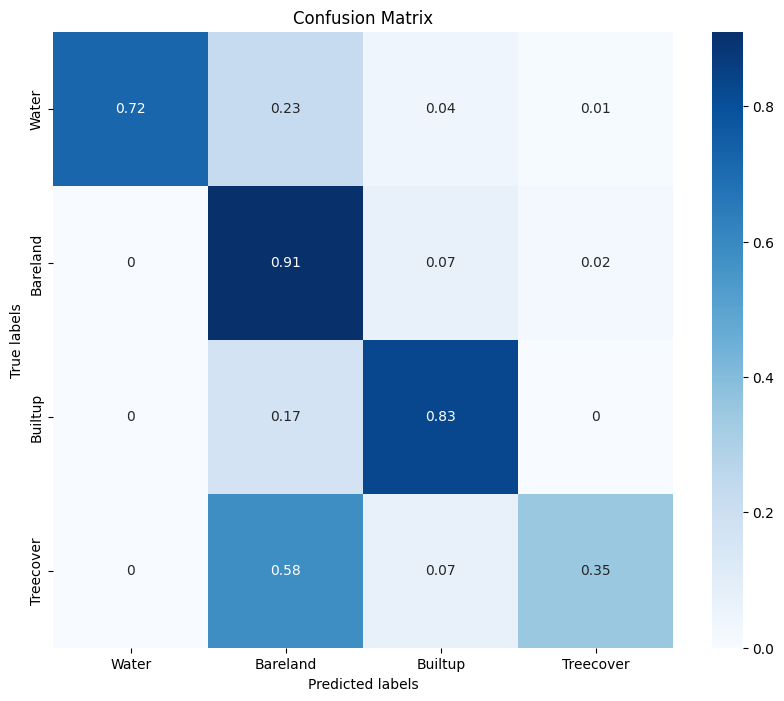

In [54]:
conf_matrix=confusion_matrix(labels_dataset.flatten(), full_map_reshape)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = np.round(conf_matrix, decimals=2)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(code_label.keys()), yticklabels=list(code_label.keys()))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [55]:
report=classification_report(labels_dataset.flatten(), full_map_reshape, target_names=code_label.keys(), output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
Water,0.856203,0.720098,0.782275,9.218360e+05
Bareland,0.815628,0.907865,0.859278,2.229441e+07
Builtup,0.887571,0.830133,0.857892,1.655157e+07
Treecover,0.663939,0.352774,0.460741,2.781426e+06
accuracy,0.837273,0.837273,0.837273,8.372733e-01
macro avg,0.805835,0.702718,0.740046,4.254925e+07
weighted avg,0.834577,0.837273,0.831018,4.254925e+07


In [56]:
pd.DataFrame.from_dict( compute_class_wise_iou(labels_dataset.flatten(), full_map_reshape, code_label.keys()), orient='index', columns=['IoU'])

,IoU
Water,0.642406
Bareland,0.753276
Builtup,0.751147
Treecover,0.299326
mean_iou,0.611539
weighted_iou,0.720372


In [57]:
print('Full Map Predictions : ')
count_class(full_map_reshape, code_label)
print('Full map true labels : ')
count_class(labels_dataset.flatten(), code_label)

Full Map Predictions : 
 Water =  0.018  Trees =  0.035  Bareland =  0.583  BuiltArea =  0.364
Full map true labels : 
 Water =  0.022  Trees =  0.065  Bareland =  0.524  BuiltArea =  0.389


In [58]:
full_map_pred_colour=convert_to_rgb(np.argmax(full_map_predictions, axis=-1))
full_map_test_colour=convert_to_rgb(labels_dataset)

In [59]:
print(full_map_pred_colour.shape)
print(full_map_test_colour.shape)
print(image_dataset.shape)

(2597, 128, 128, 3)
(2597, 128, 128, 3)
(2597, 128, 128)


Original image shape: (6272, 6784)
Number of patches: height=49, width=53
Reconstruction dimensions: (6272, 6784)


(-0.5, 6783.5, 6271.5, -0.5)

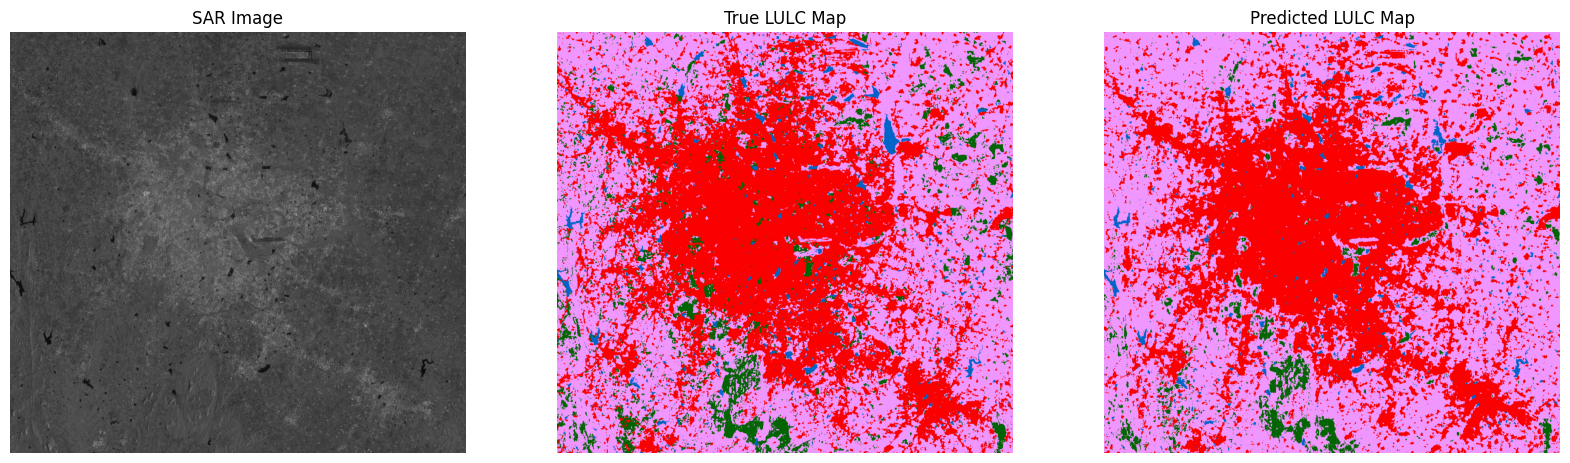

In [60]:
# Calculate correct dimensions
patch_size = 128
h, w = image.shape
n_h = h // patch_size
n_w = w // patch_size
reconstructed_height = n_h * patch_size
reconstructed_width = n_w * patch_size

print(f"Original image shape: {image.shape}")
print(f"Number of patches: height={n_h}, width={n_w}")
print(f"Reconstruction dimensions: ({reconstructed_height}, {reconstructed_width})")

plt.figure(figsize=(20, 25))

# Use the calculated dimensions
reconstructed_image = unpatchify(image_dataset, (reconstructed_height, reconstructed_width))
plt.subplot(1, 3, 1)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('SAR Image')
plt.axis('off')

reconstructed_image = unpatchify(full_map_test_colour, (reconstructed_height, reconstructed_width))
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image)
plt.title('True LULC Map')
plt.axis('off')

reconstructed_image = unpatchify(full_map_pred_colour, (reconstructed_height, reconstructed_width))
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image)
plt.title('Predicted LULC Map')
plt.axis('off')

In [61]:
# plt.figure(figsize=(20, 25))
# # (6310, 6911) (6656,  6144)
# reconstructed_image = unpatchify(image_dataset, (2688, 2816) )
# plt.subplot(1, 3, 1)
# plt.imshow(reconstructed_image, cmap='gray')
# plt.title('SAR Image')
# plt.axis('off')
# reconstructed_image = unpatchify(full_map_test_colour, (2688, 2816) )
# plt.subplot(1, 3, 2)
# plt.imshow(reconstructed_image)
# plt.title('True LULC Map')
# plt.axis('off')
# reconstructed_image = unpatchify(full_map_pred_colour, (2688, 2816))
# plt.subplot(1, 3, 3)
# plt.imshow(reconstructed_image)
# plt.title('Predicted LULC Map')
# plt.axis('off')

In [62]:
# # Ensure mask values are within valid range
# print("Unique values in y_train before clipping:", np.unique(y_train))
# y_train = np.clip(y_train, 0, 3)
# print("Unique values in y_train after clipping:", np.unique(y_train))

# # Convert mask to integers
# y_train = y_train.astype(int)

# # Convert to one-hot encoding
# y_train_one_hot = to_categorical(y_train, num_classes=4)  # Shape: (2597, 128, 128, 4)

# # Proceed with normalization and training
# x_train = np.expand_dims(patched_images_flattened, axis=-1)  # Shape: (2597, 128, 128, 1)
# x_train = x_train / 255.0

# # Train the model
# model.fit(x_train, y_train_one_hot, batch_size=16, epochs=50, validation_split=0.2)


In [63]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming x_train and y_train_one_hot are split into train and validation sets
# # Use validation data for evaluation
# x_val = x_train[:len(x_train)//5]  # Example split
# y_val_one_hot = y_train_one_hot[:len(y_train_one_hot)//5]

# # Predict on the validation set
# y_pred_one_hot = model.predict(x_val)  # Shape: (num_samples, 128, 128, num_classes)

# # Convert one-hot encoded predictions and labels to class indices
# y_pred = np.argmax(y_pred_one_hot, axis=-1)  # Predicted labels, Shape: (num_samples, 128, 128)
# y_true = np.argmax(y_val_one_hot, axis=-1)  # True labels, Shape: (num_samples, 128, 128)

# # Flatten predictions and ground truth
# y_pred_flat = y_pred.flatten()
# y_true_flat = y_true.flatten()

# # Compute confusion matrix
# conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2, 3])

# # Display confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
#             yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


In [64]:
per_sample_accuracy=[]
full_map_pred_argmax = np.argmax(full_map_predictions, axis=-1)
for i in range(full_map_pred_argmax.shape[0]):
    per_sample_accuracy.append(np.mean(full_map_pred_argmax[i].flatten() == labels_dataset[i].flatten()))


In [65]:
lower10mark = np.percentile(per_sample_accuracy, 10)
upper10mark = np.percentile(per_sample_accuracy, 90)

In [66]:
lower10_y_pred=[]
upper10_y_pred=[]
lower10_y_test=[]
upper10_y_test=[]
lower10_x_test=[]
upper10_x_test=[]
for i in range(len(per_sample_accuracy)):
    if(per_sample_accuracy[i]<=lower10mark):
        lower10_y_pred.append(full_map_pred_colour[i])
        lower10_y_test.append(full_map_test_colour[i])
        lower10_x_test.append(labels_dataset[i])
    elif(per_sample_accuracy[i]>=upper10mark):
        upper10_y_pred.append(full_map_pred_colour[i])
        upper10_y_test.append(full_map_test_colour[i])
        upper10_x_test.append(labels_dataset[i])

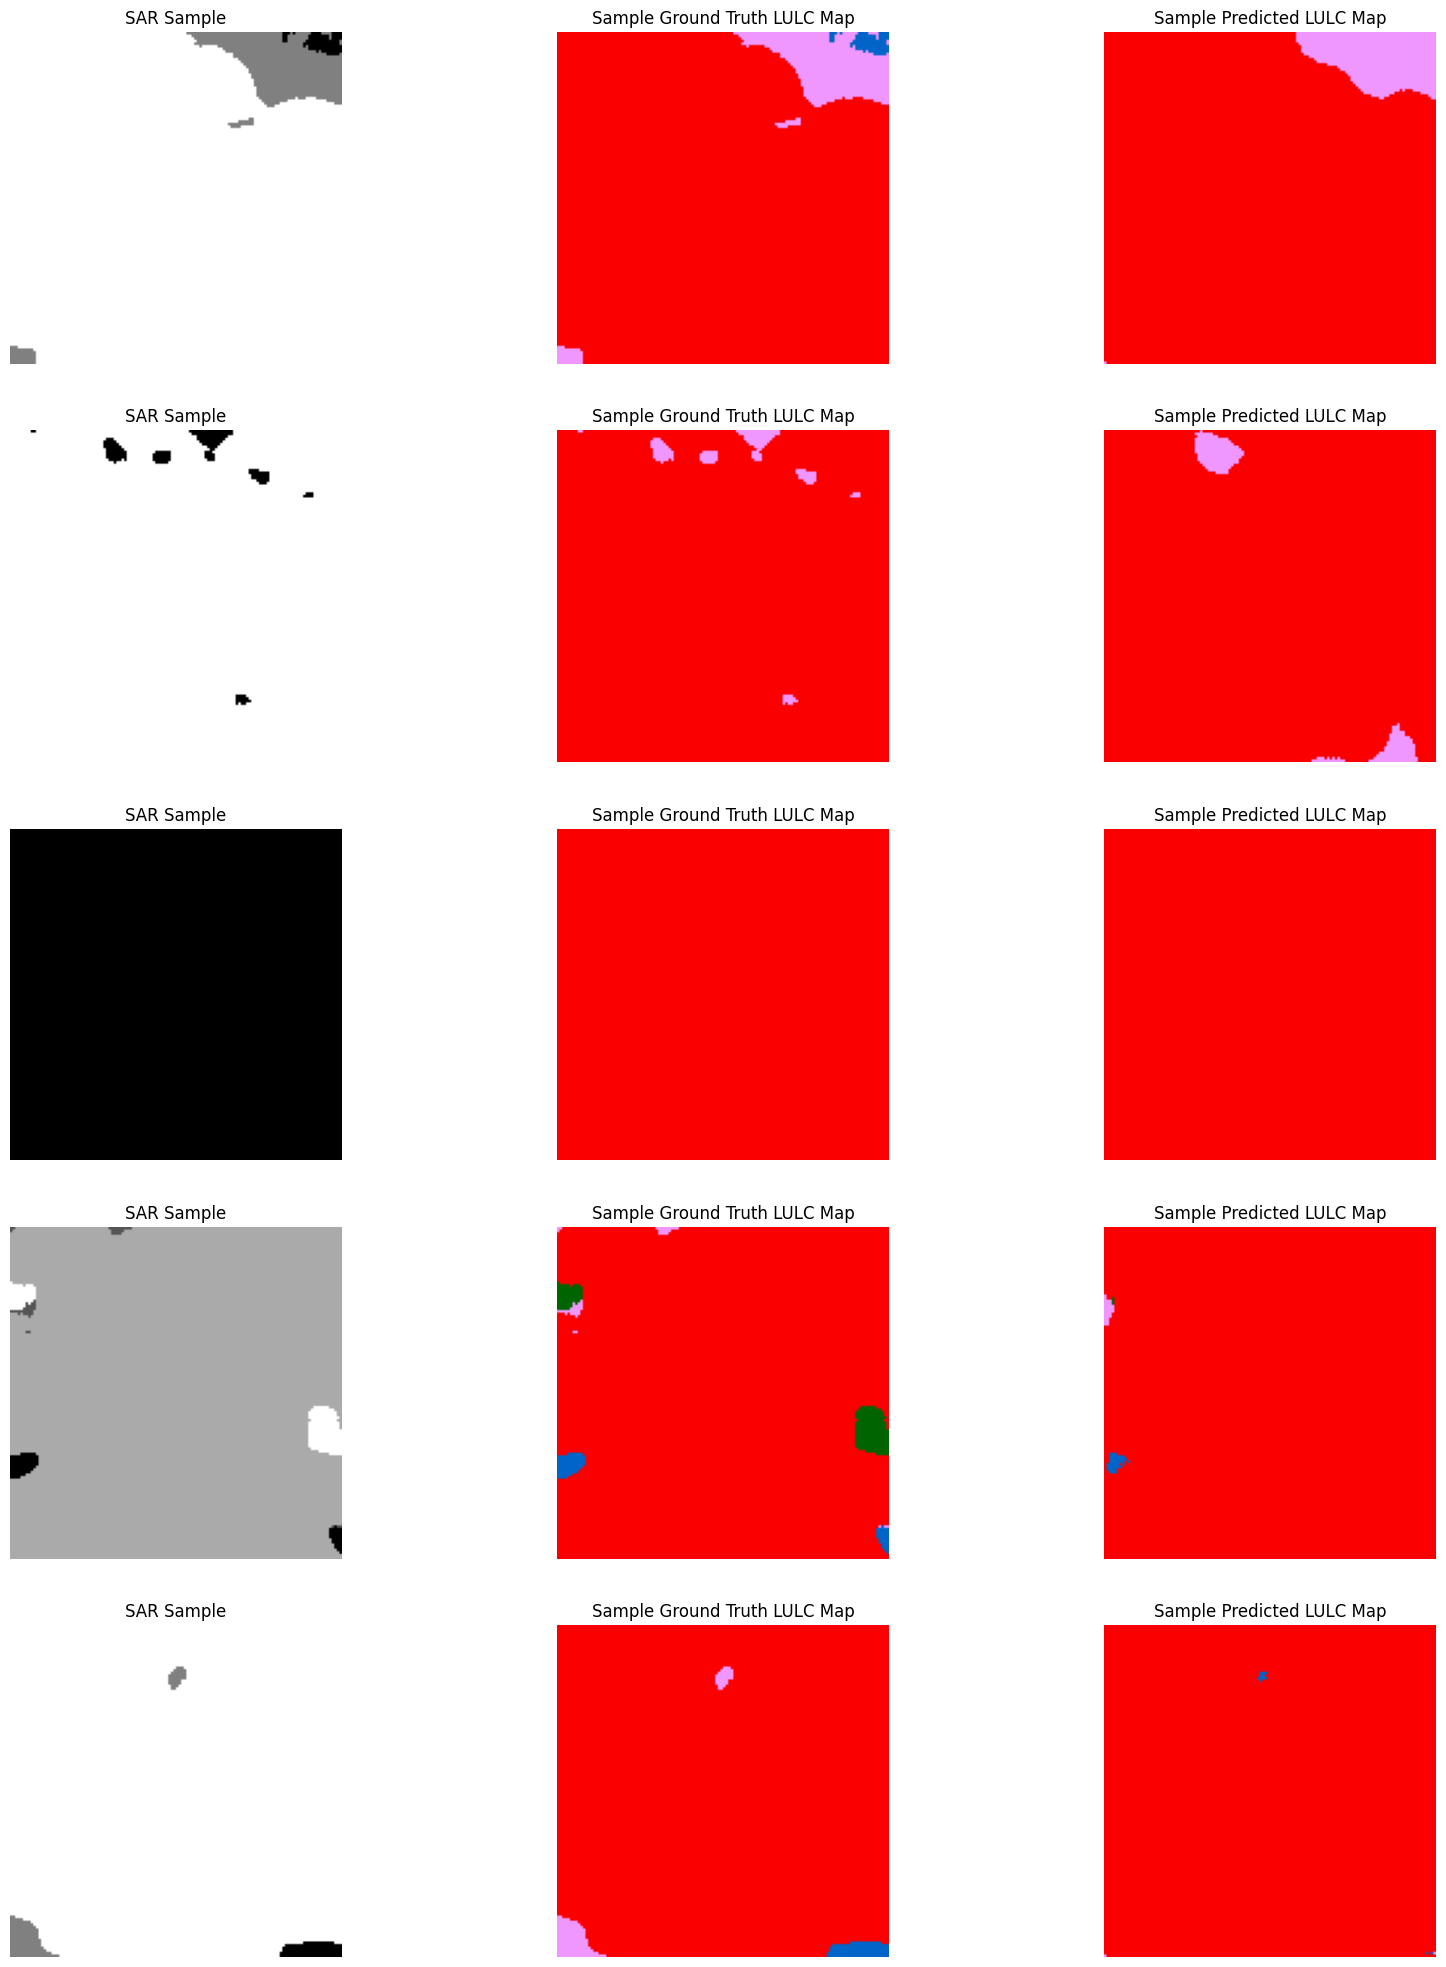

In [67]:
n_images=5
sample_index = np.random.choice(len(upper10_y_pred), n_images)
plt.figure(figsize=(20, 10*n_images/2))
for j,i in enumerate(sample_index):
    pred= upper10_y_pred[i]
    true= upper10_y_test[i]
    sar= upper10_x_test[i]
    plt.subplot(n_images, 3,(j*3)+1)
    plt.imshow(sar,cmap = 'gray')
    plt.title('SAR Sample')
    plt.axis('off')
    plt.subplot(n_images, 3,(j*3)+2)
    plt.imshow(true)
    plt.title('Sample Ground Truth LULC Map')
    plt.axis('off')
    plt.subplot(n_images, 3,(j*3)+3)
    plt.imshow(pred)
    plt.title('Sample Predicted LULC Map')
    plt.axis('off')